# MRI Images Classification

In [1]:
import random
import zipfile
import io
import numpy as np
import torch
import torchvision
import torch.nn as nn
from pyexpat import features
from PIL import Image

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


## Data Processing and Splitting

In [2]:
# Read the data

zip_file_path = "C:/Users/masat/Downloads/alzheimers.zip"
folders = ["AugmentedAlzheimerDataset/MildDemented", "AugmentedAlzheimerDataset/ModerateDemented", "AugmentedAlzheimerDataset/NonDemented", "AugmentedAlzheimerDataset/VeryMildDemented"]

X = []
y = []
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    
    file_names = zip_ref.namelist()
    for i in range(0, len(folders)):
        relevant_files = [file_name for file_name in file_names if file_name.startswith(folders[i])]
       
        for file_name in relevant_files:

            with zip_ref.open(file_name) as file:
                
                img = Image.open(io.BytesIO(file.read())).convert("RGB")
                img = img.resize((224,224))
                transform = torchvision.transforms.ToTensor()
                img = transform(img)
                X.append(img)
                y.append(i)

Text(0.5, 1.0, 'Data per class')

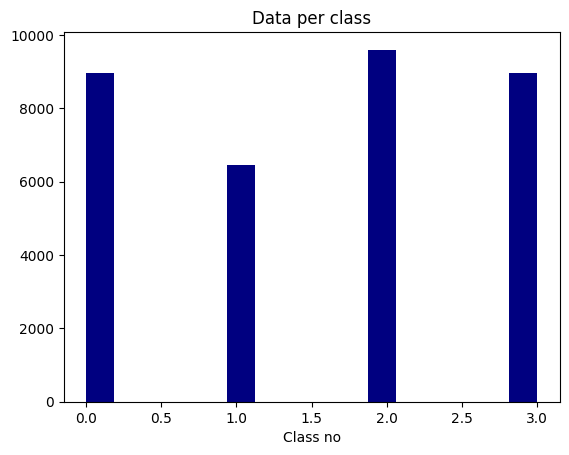

In [3]:
plt.figure()
plt.hist(y, bins=16, align='mid', color='navy')
plt.xlabel('Class no')
plt.title('Data per class')

# Data undersampling 

# TODO : Potentially I will come back here if it turns out that model doesn't perform well

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

X_train = torch.stack(X_train)
y_train = torch.tensor(y_train)
X_test = torch.stack(X_test)
y_test = torch.tensor(y_test)
X_val = torch.stack(X_val)
y_val = torch.tensor(y_val)

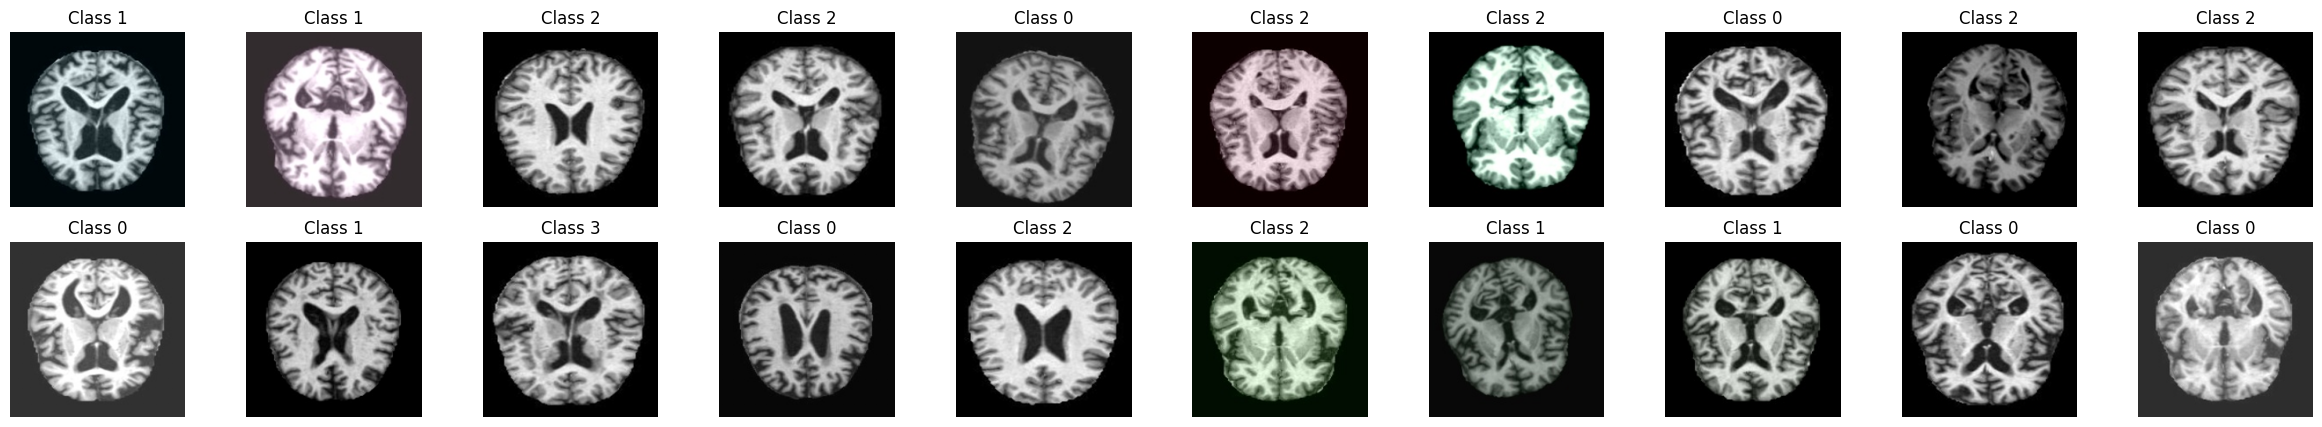

In [39]:
indices = random.choices(np.arange(0,X_train.size(0)), k=20)

plt.figure(figsize=(30,5))
for i in range(0,10):

    plt.subplot(2, 10, i+1)
    plt.imshow(X_train[indices[i]].permute(1, 2, 0).numpy(), cmap='grey')
    plt.axis('off')
    plt.title(f'Class {y_train[indices[i]]}')

    plt.subplot(2, 10, i+11)
    plt.imshow(X_train[indices[i+10]].permute(1, 2, 0).numpy(), cmap='grey')
    plt.title(f'Class {y_train[indices[i+10]]}')
    plt.axis('off')


## Model fine-tuning and training

In [5]:
from torchvision.models import efficientnet_b2

num_classes = 4

model = efficientnet_b2(pretrained=True)
model.classifier = nn.Sequential(nn.Dropout(0.2), nn.Linear(model.classifier[1].in_features, num_classes))
model = model.to(device)

for param in model.features[-3:].parameters():  # Unfreeze last 3 layers
    param.requires_grad = True



c:\Users\masat\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\masat\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [6]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet mean/std
])

# Example: Load a dataset
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [7]:
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 15  # Adjust as needed
patience = 3  # Stop if no improvement after 'patience' epochs
best_val_loss = float("inf")
counter = 0  # Track how many epochs have passed without improvement

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # ---- VALIDATION PHASE ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # ---- EARLY STOPPING CHECK ----
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0  # Reset patience counter
        torch.save(model.state_dict(), "best_model.pth")  # Save the best model
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs!")
            break  # Stop training

print("Training complete!")

Epoch 1, Train Loss: 0.4732, Val Loss: 0.1640
Epoch 2, Train Loss: 0.1505, Val Loss: 0.0763
Epoch 3, Train Loss: 0.0904, Val Loss: 0.0667
Epoch 4, Train Loss: 0.0636, Val Loss: 0.0567
Epoch 5, Train Loss: 0.0470, Val Loss: 0.0432
Epoch 6, Train Loss: 0.0543, Val Loss: 0.0548
Epoch 7, Train Loss: 0.0359, Val Loss: 0.0517
Epoch 8, Train Loss: 0.0340, Val Loss: 0.0402
Epoch 9, Train Loss: 0.0396, Val Loss: 0.0358
Epoch 10, Train Loss: 0.0252, Val Loss: 0.0845
Epoch 11, Train Loss: 0.0339, Val Loss: 0.0576
Epoch 12, Train Loss: 0.0261, Val Loss: 0.0539
Early stopping triggered after 12 epochs!
Training complete!


In [8]:
model.eval()
correct, total = 0, 0
y_test_pred = []
y_test_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        for i in range(0, labels.size(0)):
            y_test_pred.append(predicted[i].cpu().numpy())
            y_test_true.append(labels[i].cpu().numpy())
            
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 98.18%


<Figure size 640x480 with 0 Axes>

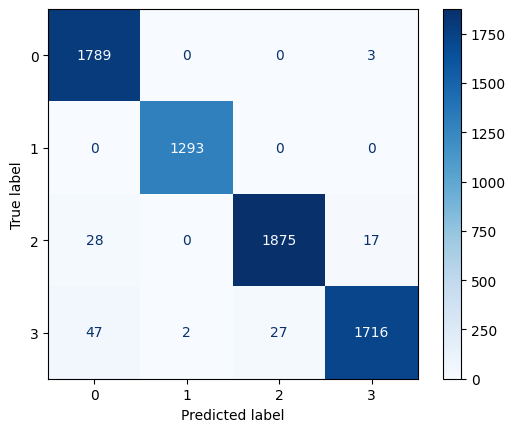

In [9]:
cm = confusion_matrix(y_test_true, y_test_pred)

plt.figure()
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)